# LCRTest1

## Setup and Data

In [1]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#These are imported specifically for the use of the histogram.
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import gridspec
from scipy import stats

#Imported for categorization of the Sources
from fractional_variability import fvar
from fermi_catalog import select_bll, select_fsrq, select_bcu

In [2]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
#print(cadence_df)

TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

In [3]:
# This function takes the dataframe of sources of variable objects, and the name of a source.
# It will sort through every entry in the dataframe, and detect consecutive entries with a flux level higher than the average.
# It counts the duration of these flaring states, and notes them in an array 'final', which it returns upon completion.
def flare_detector(name,met,flux,eflux):
    final = [0,0,0]
    k=0
    temp =[]
    temp_err=[]
    duration = []
    average=[]
    # This section is for setting up our dataframes which will be used in the following loop.
    # We primarily are eliminating outliers and NaN values that were marked with -3333.
    #sourcematrix = dataframe.loc[dataframe['source_name'] == name].reset_index(drop=True)
    fluxmatrix = flux
    averageflux = np.mean(fluxmatrix)
    errormatrix = eflux
    boolmatrix = fluxmatrix/averageflux > 1  
    boolmatrix = boolmatrix
    for i in range(len(fluxmatrix)):
        # If the flux value for index i is greater than the average, then this condition is met.
        if boolmatrix[i] == True:
            temp.append(fluxmatrix[i])
            temp_err.append(errormatrix[i])
        # If the flux value is not above average, and there are values stored in the temp array, we gather them and send them to 'final'.
        elif len(temp) != 0:
            if i != 0:
                duration = ((len(temp)))
                average = np.nanmean(temp)
                error = ((sum(k*k for k in temp_err))**0.5)*(1/(len(temp_err)))
                temp = []
                temp_err = []
                final = np.vstack([final,[duration,average,error]])
        # Otherwise, we add a row of 0's to show that the source has no flaring states.
        else:
            final = np.vstack([final,[0,0,0]])


    return final

In [4]:
# These three loops will run the flare_detector function for each category of blazar 
#for white noise like lightruves
import glob
import numpy as np

cadence='daily'
#cadence='weekly'
#cadence='monthly'

fsrq_files_white=glob.glob('./simulated_LC_FSRQ_'+cadence+'_white_noise_gaussian/sim_lc*.dat')

fsrq_flares_white = [0,0,0]
for i,file in enumerate(fsrq_files_white[0:573]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    fsrq_flares_white = np.vstack([fsrq_flares_white,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bll_files_white=glob.glob('./simulated_LC_BLL_'+cadence+'_white_noise_gaussian/sim_lc*.dat')

bll_flares_white = [0,0,0]
for i,file in enumerate(bll_files_white[0:478]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]*1.2
    eflux_sim=data_sim[:,2]
    bll_flares_white = np.vstack([bll_flares_white,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bcu_files_white=glob.glob('./simulated_LC_BCU_'+cadence+'_white_noise_gaussian/sim_lc*.dat')

bcu_flares_white = [0,0,0]
for i,file in enumerate(bcu_files_white[0:365]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    bcu_flares_white = np.vstack([bcu_flares_white,flare_detector(name,met_sim,flux_sim,eflux_sim)])

total_flares_white=np.vstack([fsrq_flares_white,bll_flares_white,bcu_flares_white])

In [5]:
# These three loops will run the flare_detector function for each category of blazar
#for red noise like lightruves
import glob
import numpy as np

cadence='daily'
#cadence='weekly'
#cadence='monthly'

fsrq_files_red=glob.glob('./simulated_LC_FSRQ_'+cadence+'_red_noise/sim_lc*.dat')

fsrq_flares_red = [0,0,0]
for i,file in enumerate(fsrq_files_red[0:573]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    fsrq_flares_red = np.vstack([fsrq_flares_red,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bll_files_red=glob.glob('./simulated_LC_BLL_'+cadence+'_red_noise/sim_lc*.dat')

bll_flares_red = [0,0,0]
for i,file in enumerate(bll_files_red[0:478]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    bll_flares_red = np.vstack([bll_flares_red,flare_detector(name,met_sim,flux_sim,eflux_sim)])

bcu_files_red=glob.glob('./simulated_LC_BCU_'+cadence+'_red_noise/sim_lc*.dat')

bcu_flares_red = [0,0,0]
for i,file in enumerate(bcu_files_red[0:365]):
    #print(i,name) 
    #print(flare_detector(name,cadence_df))
    name=str(i)

    data_sim=np.loadtxt(file)
    met_sim=data_sim[:,0]
    flux_sim=data_sim[:,1]
    eflux_sim=data_sim[:,2]
    bcu_flares_red = np.vstack([bcu_flares_red,flare_detector(name,met_sim,flux_sim,eflux_sim)])

total_flares_red=np.vstack([fsrq_flares_red,bll_flares_red,bcu_flares_red])

In [6]:
fsrq_flares_white_red=np.vstack([fsrq_flares_white,fsrq_flares_red])
bll_flares_white_red=np.vstack([bll_flares_white,bll_flares_red])
bcu_flares_white_red=np.vstack([bcu_flares_white,bcu_flares_red])

total_flares_white_red=np.vstack([fsrq_flares_white_red,bll_flares_white_red,bcu_flares_white_red])

In [7]:
fsrq_filtered_white = fsrq_flares_white[fsrq_flares_white[:,0] != 0]
fsrq_flareduration_white = fsrq_filtered_white[:,0]
fsrq_flareflux_white = fsrq_filtered_white[:,1]
fsrq_flareduration_white=np.asarray(fsrq_flareduration_white,dtype='float64')
fsrq_flareflux_white=np.asarray(fsrq_flareflux_white,dtype='float64')
fsrq_fluence_white = np.multiply(fsrq_flareflux_white,fsrq_flareduration_white)*(3*24*60*60)
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence_white)
fsrq_fluencecount_white = np.zeros(len(fsrq_fluence_white))
fsrq_fluencethresholds_white=sorted(fsrq_fluence_white)
for i in range(0,len(fsrq_fluence_white)):
    fsrq_fluencecount_white[i]=len(fsrq_fluence_white[fsrq_fluence_white>fsrq_fluencethresholds_white[i]])
pd.DataFrame(fsrq_fluencethresholds_white)

bll_filtered_white = bll_flares_white[bll_flares_white[:,0] != 0]
bll_flareduration_white = bll_filtered_white[:,0]
bll_flareflux_white = bll_filtered_white[:,1]
bll_flareduration_white=np.asarray(bll_flareduration_white,dtype='float64')
bll_flareflux_white=np.asarray(bll_flareflux_white,dtype='float64')
bll_fluence_white = np.multiply(bll_flareflux_white,bll_flareduration_white)*(3*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence_white)
bll_fluencecount_white = np.zeros(len(bll_fluence_white))
bll_fluencethresholds_white=sorted(bll_fluence_white)
for i in range(0,len(bll_fluence_white)):
    bll_fluencecount_white[i]=len(bll_fluence_white[bll_fluence_white>bll_fluencethresholds_white[i]])
pd.DataFrame(bll_fluencethresholds_white)


bcu_filtered_white = bcu_flares_white[bcu_flares_white[:,0] != 0]
bcu_flareduration_white = bcu_filtered_white[:,0]
bcu_flareflux_white = bcu_filtered_white[:,1]
bcu_flareduration_white=np.asarray(bcu_flareduration_white,dtype='float64')*(3*24*60*60)
bcu_flareflux_white=np.asarray(bcu_flareflux_white,dtype='float64')
bcu_fluence_white = np.multiply(bcu_flareflux_white,bcu_flareduration_white)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence_white)
bcu_fluencecount_white = np.zeros(len(bcu_fluence_white))
bcu_fluencethresholds_white=sorted(bcu_fluence_white)
for i in range(0,len(bcu_fluence_white)):
    bcu_fluencecount_white[i]=len(bcu_fluence_white[bcu_fluence_white>bcu_fluencethresholds_white[i]])
pd.DataFrame(bcu_fluencethresholds_white)


total_filtered_white = total_flares_white[total_flares_white[:,0] != 0]
total_flareduration_white = total_filtered_white[:,0]
total_flareflux_white = total_filtered_white[:,1]
total_flareduration_white=np.asarray(total_flareduration_white,dtype='float64')
total_flareflux_white=np.asarray(total_flareflux_white,dtype='float64')
total_fluence_white = np.multiply(total_flareflux_white,total_flareduration_white)*(3*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence_white)
total_fluencecount_white = np.zeros(len(total_fluence_white))
total_fluencethresholds_white=sorted(total_fluence_white)
for i in range(0,len(total_fluence_white)):
    total_fluencecount_white[i]=len(total_fluence_white[total_fluence_white>total_fluencethresholds_white[i]])
pd.DataFrame(total_fluencethresholds_white)

,0
0,0.005853
1,0.006542
2,0.006877
3,0.006941
4,0.007364
...,...
72968,4.290937
72969,6.248129
72970,6.248485
72971,6.279833


In [8]:
fsrq_filtered_red = fsrq_flares_red[fsrq_flares_red[:,0] != 0]
fsrq_flareduration_red = fsrq_filtered_red[:,0]
fsrq_flareflux_red = fsrq_filtered_red[:,1]
fsrq_flareduration_red=np.asarray(fsrq_flareduration_red,dtype='float64')
fsrq_flareflux_red=np.asarray(fsrq_flareflux_red,dtype='float64')
fsrq_fluence_red = np.multiply(fsrq_flareflux_red,fsrq_flareduration_red)*(3*24*60*60)
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence_red)
fsrq_fluencecount_red = np.zeros(len(fsrq_fluence_red))
fsrq_fluencethresholds_red=sorted(fsrq_fluence_red)
for i in range(0,len(fsrq_fluence_red)):
    fsrq_fluencecount_red[i]=len(fsrq_fluence_red[fsrq_fluence_red>fsrq_fluencethresholds_red[i]])
pd.DataFrame(fsrq_fluencethresholds_red)

bll_filtered_red = bll_flares_red[bll_flares_red[:,0] != 0]
bll_flareduration_red = bll_filtered_red[:,0]
bll_flareflux_red = bll_filtered_red[:,1]
bll_flareduration_red=np.asarray(bll_flareduration_red,dtype='float64')
bll_flareflux_red=np.asarray(bll_flareflux_red,dtype='float64')
bll_fluence_red = np.multiply(bll_flareflux_red,bll_flareduration_red)*(3*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence_red)
bll_fluencecount_red = np.zeros(len(bll_fluence_red))
bll_fluencethresholds_red=sorted(bll_fluence_red)
for i in range(0,len(bll_fluence_red)):
    bll_fluencecount_red[i]=len(bll_fluence_red[bll_fluence_red>bll_fluencethresholds_red[i]])
pd.DataFrame(bll_fluencethresholds_red)


bcu_filtered_red = bcu_flares_red[bcu_flares_red[:,0] != 0]
bcu_flareduration_red = bcu_filtered_red[:,0]
bcu_flareflux_red = bcu_filtered_red[:,1]
bcu_flareduration_red=np.asarray(bcu_flareduration_red,dtype='float64')*(3*24*60*60)
bcu_flareflux_red=np.asarray(bcu_flareflux_red,dtype='float64')
bcu_fluence_red = np.multiply(bcu_flareflux_red,bcu_flareduration_red)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence_red)
bcu_fluencecount_red = np.zeros(len(bcu_fluence_red))
bcu_fluencethresholds_red=sorted(bcu_fluence_red)
for i in range(0,len(bcu_fluence_red)):
    bcu_fluencecount_red[i]=len(bcu_fluence_red[bcu_fluence_red>bcu_fluencethresholds_red[i]])
pd.DataFrame(bcu_fluencethresholds_red)


total_filtered_red = total_flares_red[total_flares_red[:,0] != 0]
total_flareduration_red = total_filtered_red[:,0]
total_flareflux_red = total_filtered_red[:,1]
total_flareduration_red=np.asarray(total_flareduration_red,dtype='float64')
total_flareflux_red=np.asarray(total_flareflux_red,dtype='float64')
total_fluence_red = np.multiply(total_flareflux_red,total_flareduration_red)*(3*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence_red)
total_fluencecount_red = np.zeros(len(total_fluence_red))
total_fluencethresholds_red=sorted(total_fluence_red)
for i in range(0,len(total_fluence_red)):
    total_fluencecount_red[i]=len(total_fluence_red[total_fluence_red>total_fluencethresholds_red[i]])
pd.DataFrame(total_fluencethresholds_red)

,0
0,0.025411
1,0.031082
2,0.031663
3,0.031961
4,0.032034
...,...
8329,221.196452
8330,235.232535
8331,286.997797
8332,313.756092


In [9]:
fsrq_filtered_white_red = fsrq_flares_white_red[fsrq_flares_white_red[:,0] != 0]
fsrq_flareduration_white_red = fsrq_filtered_white_red[:,0]
fsrq_flareflux_white_red = fsrq_filtered_white_red[:,1]
fsrq_flareduration_white_red=np.asarray(fsrq_flareduration_white_red,dtype='float64')
fsrq_flareflux_white_red=np.asarray(fsrq_flareflux_white_red,dtype='float64')
fsrq_fluence_white_red = np.multiply(fsrq_flareflux_white_red,fsrq_flareduration_white_red)*(3*24*60*60)
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence_white_red)
fsrq_fluencecount_white_red = np.zeros(len(fsrq_fluence_white_red))
fsrq_fluencethresholds_white_red=sorted(fsrq_fluence_white_red)
for i in range(0,len(fsrq_fluence_white_red)):
    fsrq_fluencecount_white_red[i]=len(fsrq_fluence_white_red[fsrq_fluence_white_red>fsrq_fluencethresholds_white_red[i]])
pd.DataFrame(fsrq_fluencethresholds_white_red)

bll_filtered_white_red = bll_flares_white_red[bll_flares_white_red[:,0] != 0]
bll_flareduration_white_red = bll_filtered_white_red[:,0]
bll_flareflux_white_red = bll_filtered_white_red[:,1]
bll_flareduration_white_red=np.asarray(bll_flareduration_white_red,dtype='float64')
bll_flareflux_white_red=np.asarray(bll_flareflux_white_red,dtype='float64')
bll_fluence_white_red = np.multiply(bll_flareflux_white_red,bll_flareduration_white_red)*(3*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence_white_red)
bll_fluencecount_white_red = np.zeros(len(bll_fluence_white_red))
bll_fluencethresholds_white_red=sorted(bll_fluence_white_red)
for i in range(0,len(bll_fluence_white_red)):
    bll_fluencecount_white_red[i]=len(bll_fluence_white_red[bll_fluence_white_red>bll_fluencethresholds_white_red[i]])
pd.DataFrame(bll_fluencethresholds_white_red)


bcu_filtered_white_red = bcu_flares_white_red[bcu_flares_white_red[:,0] != 0]
bcu_flareduration_white_red = bcu_filtered_white_red[:,0]
bcu_flareflux_white_red = bcu_filtered_white_red[:,1]
bcu_flareduration_white_red=np.asarray(bcu_flareduration_white_red,dtype='float64')*(3*24*60*60)
bcu_flareflux_white_red=np.asarray(bcu_flareflux_white_red,dtype='float64')
bcu_fluence_white_red = np.multiply(bcu_flareflux_white_red,bcu_flareduration_white_red)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence_white_red)
bcu_fluencecount_white_red = np.zeros(len(bcu_fluence_white_red))
bcu_fluencethresholds_white_red=sorted(bcu_fluence_white_red)
for i in range(0,len(bcu_fluence_white_red)):
    bcu_fluencecount_white_red[i]=len(bcu_fluence_white_red[bcu_fluence_white_red>bcu_fluencethresholds_white_red[i]])
pd.DataFrame(bcu_fluencethresholds_white_red)


total_filtered_white_red = total_flares_white_red[total_flares_white_red[:,0] != 0]
total_flareduration_white_red = total_filtered_white_red[:,0]
total_flareflux_white_red = total_filtered_white_red[:,1]
total_flareduration_white_red=np.asarray(total_flareduration_white_red,dtype='float64')
total_flareflux_white_red=np.asarray(total_flareflux_white_red,dtype='float64')
total_fluence_white_red = np.multiply(total_flareflux_white_red,total_flareduration_white_red)*(3*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence_white_red)
total_fluencecount_white_red = np.zeros(len(total_fluence_white_red))
total_fluencethresholds_white_red=sorted(total_fluence_white_red)
for i in range(0,len(total_fluence_white_red)):
    total_fluencecount_white_red[i]=len(total_fluence_white_red[total_fluence_white_red>total_fluencethresholds_white_red[i]])
pd.DataFrame(total_fluencethresholds_white_red)

,0
0,0.005853
1,0.006542
2,0.006877
3,0.006941
4,0.007364
...,...
81302,221.196452
81303,235.232535
81304,286.997797
81305,313.756092


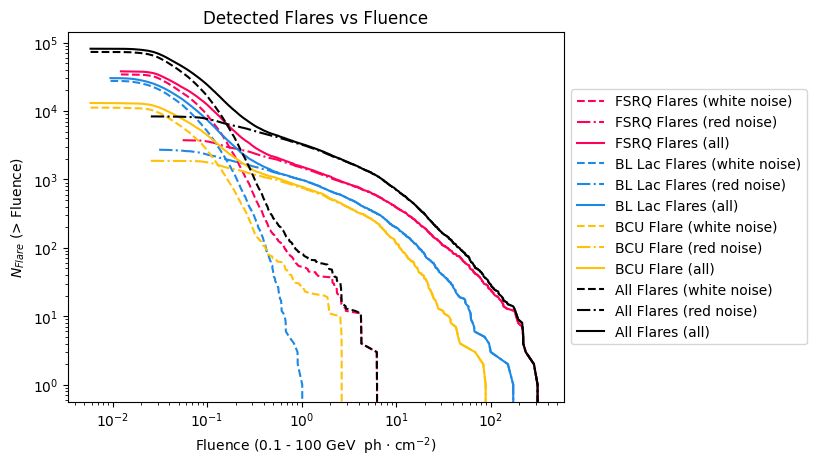

<Figure size 640x480 with 0 Axes>

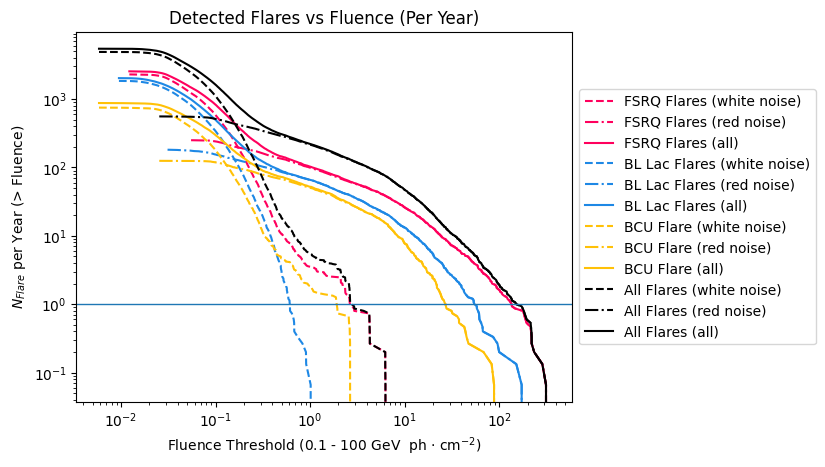

In [10]:
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds_white,fsrq_fluencecount_white, color=cl[0], linestyle='--', label=label_white[0])
plt.plot(fsrq_fluencethresholds_red,fsrq_fluencecount_red, color=cl[0], linestyle='-.', label=label_red[0])
plt.plot(fsrq_fluencethresholds_white_red,fsrq_fluencecount_white_red, color=cl[0], linestyle='-', label=label_all[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')

plt.plot(bll_fluencethresholds_white,bll_fluencecount_white, color=cl[1], linestyle='--', label=label_white[1])
plt.plot(bll_fluencethresholds_red,bll_fluencecount_red, color=cl[1], linestyle='-.', label=label_red[1])
plt.plot(bll_fluencethresholds_white_red,bll_fluencecount_white_red, color=cl[1], linestyle='-',  label=label_all[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds_white,bcu_fluencecount_white, color=cl[2], linestyle='--', label=label_white[2])
plt.plot(bcu_fluencethresholds_red,bcu_fluencecount_red, color=cl[2], linestyle='-.', label=label_red[2])
plt.plot(bcu_fluencethresholds_white_red,bcu_fluencecount_white_red, color=cl[2], linestyle='-',  label=label_all[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds_white,total_fluencecount_white, color=cl[3], linestyle='--', label=label_white[3])
plt.plot(total_fluencethresholds_red,total_fluencecount_red, color=cl[3], linestyle='-.', label=label_red[3])
plt.plot(total_fluencethresholds_white_red,total_fluencecount_white_red, color=cl[3], linestyle='-',  label=label_all[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure()
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds_white,fsrq_fluencecount_white/15, color=cl[0], linestyle='--', label=label_white[0])
plt.plot(fsrq_fluencethresholds_red,fsrq_fluencecount_red/15, color=cl[0], linestyle='-.', label=label_red[0])
plt.plot(fsrq_fluencethresholds_white_red,fsrq_fluencecount_white_red/15, color=cl[0], linestyle='-', label=label_all[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')

plt.plot(bll_fluencethresholds_white,bll_fluencecount_white/15, color=cl[1], linestyle='--', label=label_white[1])
plt.plot(bll_fluencethresholds_red,bll_fluencecount_red/15, color=cl[1], linestyle='-.', label=label_red[1])
plt.plot(bll_fluencethresholds_white_red,bll_fluencecount_white_red/15, color=cl[1], linestyle='-',  label=label_all[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds_white,bcu_fluencecount_white/15, color=cl[2], linestyle='--', label=label_white[2])
plt.plot(bcu_fluencethresholds_red,bcu_fluencecount_red/15, color=cl[2], linestyle='-.', label=label_red[2])
plt.plot(bcu_fluencethresholds_white_red,bcu_fluencecount_white_red/15, color=cl[2], linestyle='-',  label=label_all[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds_white,total_fluencecount_white/15, color=cl[3], linestyle='--', label=label_white[3])
plt.plot(total_fluencethresholds_red,total_fluencecount_red/15, color=cl[3], linestyle='-.', label=label_red[3])
plt.plot(total_fluencethresholds_white_red,total_fluencecount_white_red/15, color=cl[3], linestyle='-',  label=label_all[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


<Figure size 640x480 with 0 Axes>

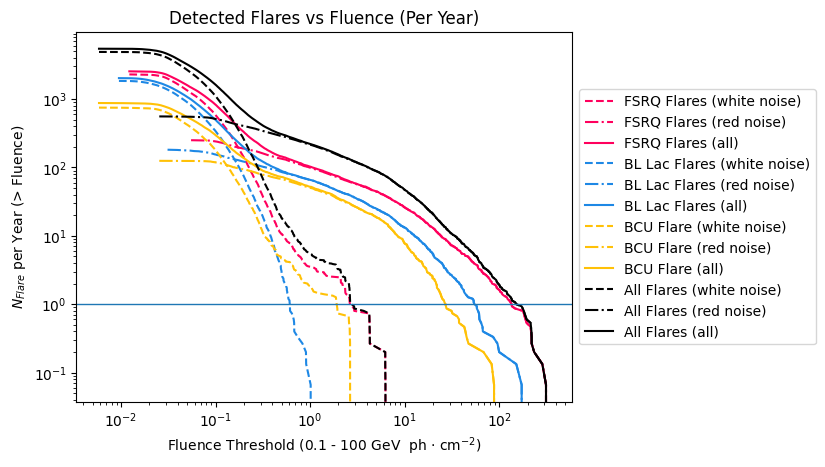

In [11]:

plt.figure()
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds_white,fsrq_fluencecount_white/15, color=cl[0], linestyle='--', label=label_white[0])
plt.plot(fsrq_fluencethresholds_red,fsrq_fluencecount_red/15, color=cl[0], linestyle='-.', label=label_red[0])
plt.plot(fsrq_fluencethresholds_white_red,fsrq_fluencecount_white_red/15, color=cl[0], linestyle='-', label=label_all[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')

plt.plot(bll_fluencethresholds_white,bll_fluencecount_white/15, color=cl[1], linestyle='--', label=label_white[1])
plt.plot(bll_fluencethresholds_red,bll_fluencecount_red/15, color=cl[1], linestyle='-.', label=label_red[1])
plt.plot(bll_fluencethresholds_white_red,bll_fluencecount_white_red/15, color=cl[1], linestyle='-',  label=label_all[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds_white,bcu_fluencecount_white/15, color=cl[2], linestyle='--', label=label_white[2])
plt.plot(bcu_fluencethresholds_red,bcu_fluencecount_red/15, color=cl[2], linestyle='-.', label=label_red[2])
plt.plot(bcu_fluencethresholds_white_red,bcu_fluencecount_white_red/15, color=cl[2], linestyle='-',  label=label_all[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds_white,total_fluencecount_white/15, color=cl[3], linestyle='--', label=label_white[3])
plt.plot(total_fluencethresholds_red,total_fluencecount_red/15, color=cl[3], linestyle='-.', label=label_red[3])
plt.plot(total_fluencethresholds_white_red,total_fluencecount_white_red/15, color=cl[3], linestyle='-',  label=label_all[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [12]:
base = 'shared_plot_arrays/'
bcu_fluencecount_rep=np.load(base+'bcu_fluencecount.npy')
bll_fluencecount_rep=np.load(base+'bll_fluencecount.npy')
fsrq_fluencecount_rep=np.load(base+'fsrq_fluencecount.npy')[:-1]
bcu_fluencecount_error_rep=np.load(base+'bcu_fluencecount_error.npy')
bll_fluencecount_error_rep=np.load(base+'bll_fluencecount_error.npy')
fsrq_fluencecount_error_rep=np.load(base+'fsrq_fluencecount_error.npy')[:-1]
bll_fluencethresholds_rep=np.load(base+'bll_fluencethresholds.npy')
bcu_fluencethresholds_rep=np.load(base+'bcu_fluencethresholds.npy')
fsrq_fluencethresholds_rep=np.load(base+'fsrq_fluencethresholds.npy')[:-1]

<Figure size 640x480 with 0 Axes>

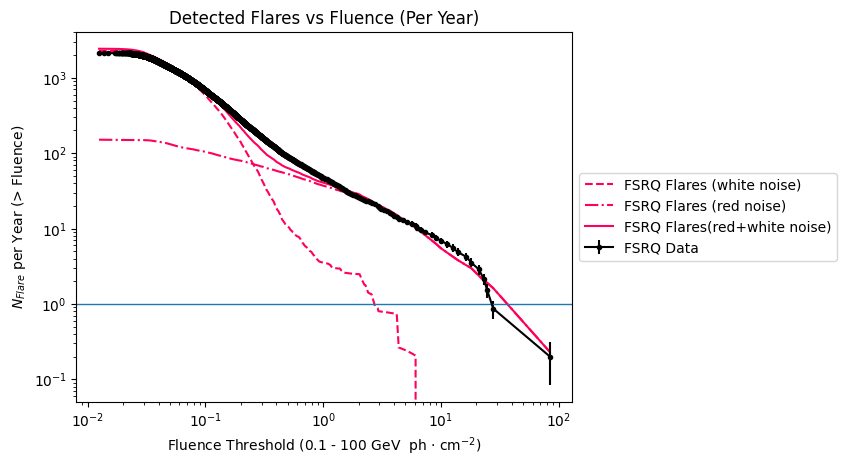

In [13]:
fsrq_fluencecount_red_scaled=fsrq_fluencecount_red*0.6
fsrq_fluencethresholds_red_scaled=1.7*np.array(fsrq_fluencethresholds_red)*np.min(fsrq_fluencethresholds_rep[fsrq_fluencethresholds_rep>0])/np.min(fsrq_fluencethresholds_red)

from scipy.interpolate import interp1d
interp_function_white = interp1d(fsrq_fluencethresholds_white, fsrq_fluencecount_white, kind='linear', fill_value="extrapolate")
fsrq_fluencecount_white_interp = interp_function_white(fsrq_fluencethresholds_rep[::10])
fsrq_fluencecount_white_interp[fsrq_fluencecount_white_interp < 0] = 0

interp_function_red = interp1d(fsrq_fluencethresholds_red_scaled, fsrq_fluencecount_red_scaled, kind='linear', fill_value="extrapolate")
fsrq_fluencecount_red_interp = interp_function_red(fsrq_fluencethresholds_rep[::10])
#fsrq_fluencecount_red_interp[fsrq_fluencecount_red_interp < 0] = 0

plt.figure()
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(fsrq_fluencethresholds_rep[::10],fsrq_fluencecount_white_interp/15, color=cl[0], linestyle='--', label=label_white[0])
plt.plot(fsrq_fluencethresholds_rep[::10],fsrq_fluencecount_red_interp/15, color=cl[0], linestyle='-.', label=label_red[0])
#plt.plot(fsrq_fluencethresholds_white_red,fsrq_fluencecount_white_red/15, color=cl[0], linestyle='-', label=label_all[0])

plt.plot(fsrq_fluencethresholds_rep[::10],(fsrq_fluencecount_red_interp+fsrq_fluencecount_white_interp)/15., color=cl[0], linestyle='-', label='FSRQ Flares(red+white noise)')

plt.errorbar(fsrq_fluencethresholds_rep[::10], fsrq_fluencecount_rep[::10], 
             yerr=fsrq_fluencecount_error_rep[::10]/15, 
             label='FSRQ Data', marker='.',color='k')
plt.yscale('log')
plt.xscale('log')

plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('FSRQ_red_plus_white_noise_simulations.png',bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

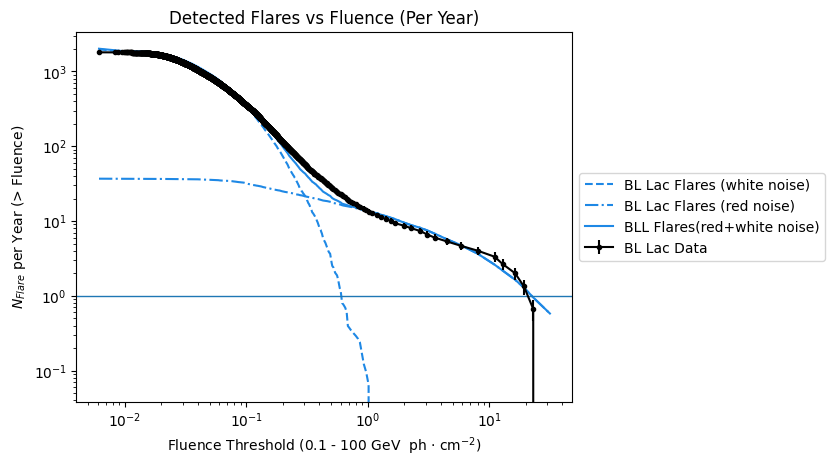

In [14]:
bll_fluencecount_red_scaled=bll_fluencecount_red*0.2
bll_fluencethresholds_red_scaled=5.5*np.array(bll_fluencethresholds_red)*np.min(bll_fluencethresholds_rep[bll_fluencethresholds_rep>0])/np.min(bll_fluencethresholds_red)

from scipy.interpolate import interp1d
interp_function_white = interp1d(bll_fluencethresholds_white, bll_fluencecount_white, kind='linear', fill_value="extrapolate")
bll_fluencecount_white_interp = interp_function_white(bll_fluencethresholds_rep[::10])
bll_fluencecount_white_interp[bll_fluencecount_white_interp < 0] = 0

interp_function_red = interp1d(bll_fluencethresholds_red_scaled, bll_fluencecount_red_scaled, kind='linear', fill_value="extrapolate")
bll_fluencecount_red_interp = interp_function_red(bll_fluencethresholds_rep[::10])
#fsrq_fluencecount_red_interp[fsrq_fluencecount_red_interp < 0] = 0

plt.figure()
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(bll_fluencethresholds_rep[::10],bll_fluencecount_white_interp/15, color=cl[1], linestyle='--', label=label_white[1])
plt.plot(bll_fluencethresholds_rep[::10],bll_fluencecount_red_interp/15, color=cl[1], linestyle='-.', label=label_red[1])

plt.plot(bll_fluencethresholds_rep[::10],(bll_fluencecount_red_interp+bll_fluencecount_white_interp)/15., color=cl[1], linestyle='-', label='BLL Flares(red+white noise)')

plt.errorbar(bll_fluencethresholds_rep[::10], bll_fluencecount_rep[::10], 
             yerr=bll_fluencecount_error_rep[::10]/15, 
             label='BL Lac Data', marker='.',color='k')
plt.yscale('log')
plt.xscale('log')

plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('BLL_red_plus_white_noise_simulations.png',bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

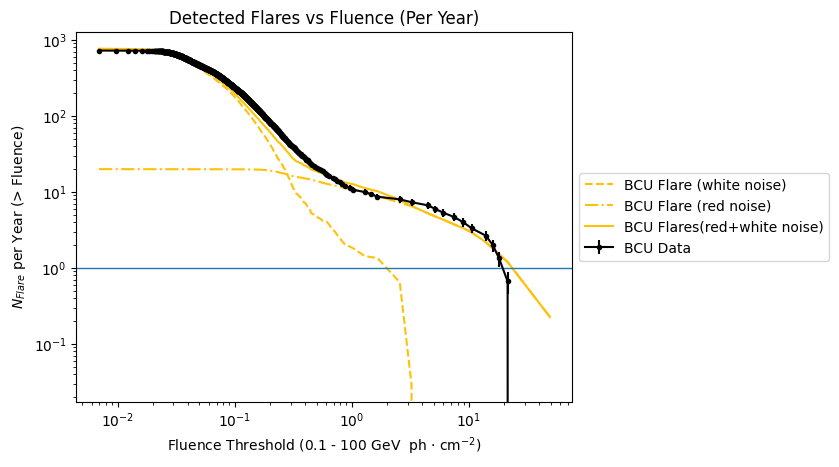

In [15]:
bcu_fluencecount_red_scaled=bcu_fluencecount_red*0.16
bcu_fluencethresholds_red_scaled=7.5*np.array(bcu_fluencethresholds_red)*np.min(bcu_fluencethresholds_rep[bcu_fluencethresholds_rep>0])/np.min(bcu_fluencethresholds_red)

from scipy.interpolate import interp1d
interp_function_white = interp1d(bcu_fluencethresholds_white, bcu_fluencecount_white, kind='linear', fill_value="extrapolate")
bcu_fluencecount_white_interp = interp_function_white(bcu_fluencethresholds_rep[::10])
bcu_fluencecount_white_interp[bcu_fluencecount_white_interp < 0] = 0

interp_function_red = interp1d(bcu_fluencethresholds_red_scaled, bcu_fluencecount_red_scaled, kind='linear', fill_value="extrapolate")
bcu_fluencecount_red_interp = interp_function_red(bcu_fluencethresholds_rep[::10])

plt.figure()
label_white = ['FSRQ Flares (white noise)','BL Lac Flares (white noise)','BCU Flare (white noise)','All Flares (white noise)'] # List of labels for categories
label_red = ['FSRQ Flares (red noise)','BL Lac Flares (red noise)','BCU Flare (red noise)','All Flares (red noise)'] # List of labels for categories
label_all = ['FSRQ Flares (all)','BL Lac Flares (all)','BCU Flare (all)','All Flares (all)'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories
plt.figure()
plt.plot(bcu_fluencethresholds_rep[::10],bcu_fluencecount_white_interp/15, color=cl[2], linestyle='--', label=label_white[2])
plt.plot(bcu_fluencethresholds_rep[::10],bcu_fluencecount_red_interp/15, color=cl[2], linestyle='-.', label=label_red[2])

plt.plot(bcu_fluencethresholds_rep[::10],(bcu_fluencecount_red_interp+bcu_fluencecount_white_interp)/15., color=cl[2], linestyle='-', label='BCU Flares(red+white noise)')


plt.errorbar(bcu_fluencethresholds_rep[::10], bcu_fluencecount_rep[::10], 
             yerr=bcu_fluencecount_error_rep[::10]/15, 
             label='BCU Data', marker='.',color='k')
plt.yscale('log')
plt.xscale('log')

plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('BCU_red_plus_white_noise_simulations.png',bbox_inches='tight')

In [16]:
np.save('red_noise_simulated_fsrq_fluencecount_scaled.npy',fsrq_fluencecount_red_interp)
np.save('red_noise_simulated_fsrq_fluencethresholds_scaled.npy',fsrq_fluencethresholds_rep[::10])
np.save('red_noise_simulated_bll_fluencecount_scaled.npy',bll_fluencecount_red_interp)
np.save('red_noise_simulated_bll_fluencethresholds_scaled.npy',bll_fluencethresholds_rep[::10])
np.save('red_noise_simulated_bcu_fluencecount_scaled.npy',bcu_fluencecount_red_interp)
np.save('red_noise_simulated_bcu_fluencethresholds_scaled.npy',bcu_fluencethresholds_rep[::10])


In [17]:
np.save('white_noise_simulated_fsrq_fluencecount_scaled.npy',fsrq_fluencecount_white_interp)
np.save('white_noise_simulated_fsrq_fluencethresholds_scaled.npy',fsrq_fluencethresholds_rep[::10])
np.save('white_noise_simulated_bll_fluencecount_scaled.npy',bll_fluencecount_white_interp)
np.save('white_noise_simulated_bll_fluencethresholds_scaled.npy',bll_fluencethresholds_rep[::10])
np.save('white_noise_simulated_bcu_fluencecount_scaled.npy',bcu_fluencecount_white_interp)
np.save('white_noise_simulated_bcu_fluencethresholds_scaled.npy',bcu_fluencethresholds_rep[::10])


In [18]:
np.save('summed_noise_simulated_fsrq_fluencecount_scaled.npy',fsrq_fluencecount_white_interp+fsrq_fluencecount_red_interp)
np.save('summed_noise_simulated_fsrq_fluencethresholds_scaled.npy',fsrq_fluencethresholds_rep[::10])
np.save('summed_noise_simulated_bll_fluencecount_scaled.npy',bll_fluencecount_white_interp+bll_fluencecount_red_interp)
np.save('summed_noise_simulated_bll_fluencethresholds_scaled.npy',bll_fluencethresholds_rep[::10])
np.save('summed_noise_simulated_bcu_fluencecount_scaled.npy',bcu_fluencecount_white_interp+bcu_fluencecount_red_interp)
np.save('summed_noise_simulated_bcu_fluencethresholds_scaled.npy',bcu_fluencethresholds_rep[::10])
